# Load data

In [ ]:
!pip install pandas matplotlib seaborn scikit-learn sentence-transformers rouge-score

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
import nltk
import numpy as np

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# Origin data before clean

In [ ]:
import pandas as pd
from rouge_score import rouge_scorer

test_df1 = pd.read_csv("/content/corpus 1 (1).csv")

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_list, rouge2_list, rougel_list = [], [], []

for ref, pred in zip(test_df1['description_html_clean'].fillna(""), test_df1['description_short'].fillna("")):
    scores = scorer.score(ref, pred)
    rouge1_list.append(scores['rouge1'].fmeasure)
    rouge2_list.append(scores['rouge2'].fmeasure)
    rougel_list.append(scores['rougeL'].fmeasure)

test_df1['ROUGE-1_short_vs_html'] = rouge1_list
test_df1['ROUGE-2_short_vs_html'] = rouge2_list
test_df1['ROUGE-L_short_vs_html'] = rougel_list

In [ ]:
print(len(test_df1))

2979


In [ ]:
short_texts1 = test_df1['description_short'].fillna("").astype(str).tolist()
html_texts1 = test_df1['description_html_clean'].fillna("").astype(str).tolist()

emb_short1 = model.encode(short_texts1, convert_to_tensor=True, show_progress_bar=True)
emb_html1 = model.encode(html_texts1, convert_to_tensor=True, show_progress_bar=True)

cos_sim1 = cosine_similarity(emb_short1.cpu(), emb_html1.cpu()).diagonal()

test_df1['cosine_short_vs_html'] = cos_sim1

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

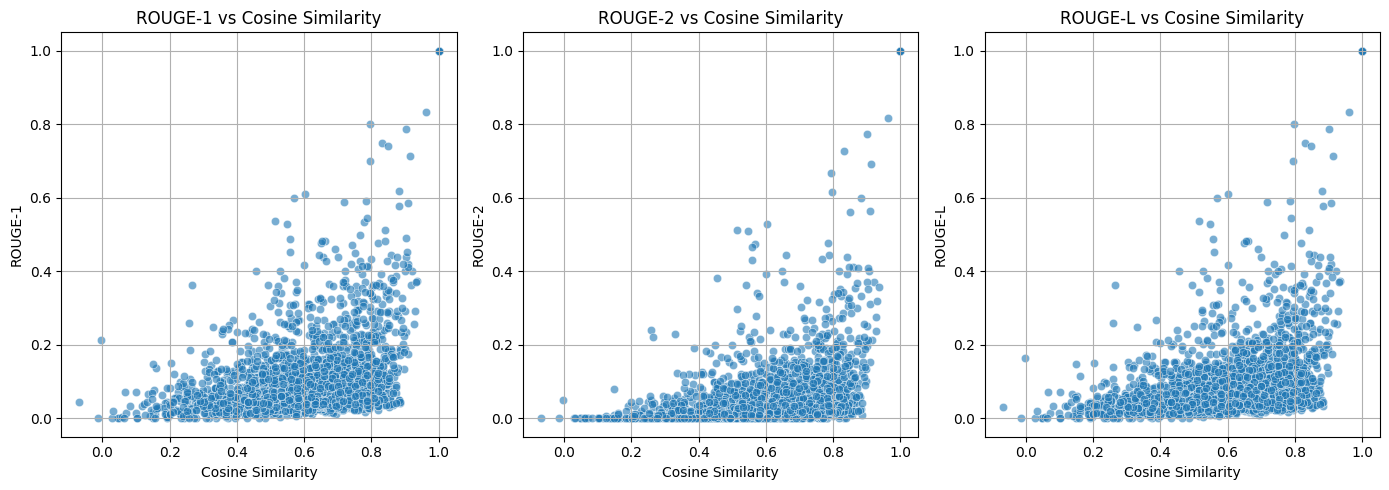

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x=test_df1['cosine_short_vs_html'], y=test_df1['ROUGE-1_short_vs_html'], alpha=0.6)
plt.xlabel("Cosine Similarity")
plt.ylabel("ROUGE-1")
plt.title("ROUGE-1 vs Cosine Similarity")
plt.grid(True)

plt.subplot(1, 3, 2)
sns.scatterplot(x=test_df1['cosine_short_vs_html'], y=test_df1['ROUGE-2_short_vs_html'], alpha=0.6)
plt.xlabel("Cosine Similarity")
plt.ylabel("ROUGE-2")
plt.title("ROUGE-2 vs Cosine Similarity")
plt.grid(True)

plt.subplot(1, 3, 3)
sns.scatterplot(x=test_df1['cosine_short_vs_html'], y=test_df1['ROUGE-L_short_vs_html'], alpha=0.6)
plt.xlabel("Cosine Similarity")
plt.ylabel("ROUGE-L")
plt.title("ROUGE-L vs Cosine Similarity")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
filtered_df = test_df1[
    (
        ((test_df1['ROUGE-1_short_vs_html'] >= 0.1) & (test_df1['ROUGE-1_short_vs_html'] < 0.97)) |
        ((test_df1['ROUGE-2_short_vs_html'] >= 0.1) & (test_df1['ROUGE-2_short_vs_html'] < 0.97)) |
        ((test_df1['ROUGE-L_short_vs_html'] >= 0.1) & (test_df1['ROUGE-L_short_vs_html'] < 0.97))
    ) &
    ((test_df1['cosine_short_vs_html'] >= 0.4) & (test_df1['cosine_short_vs_html'] < 0.97))
] #<0.97 is the same as 1.0 but to avoid floating point issues
print(len(filtered_df))

841


In [ ]:
import pandas as pd

train_df = pd.read_csv("/content/train_data.csv")
# filtered_df = pd.read_csv("/content/filtered_output_rouge.csv")

filtered_unique = filtered_df[~filtered_df['description_short'].isin(train_df['description_short'])]
print(len(filtered_unique))

789


In [ ]:
filtered_unique.to_csv("/content/test_rouge_cosine_789.csv", index=False)

In [ ]:
import pandas as pd

# Đọc file đầu vào
df = pd.read_csv("/content/test_rouge_cosine_789.csv")

# Lấy 600 instance ngẫu nhiên
random_600 = df.sample(n=600, random_state=42)
random_600.to_csv("/content/test_random_600.csv", index=False)

# Lấy 400 instance ngẫu nhiên
random_400 = df.sample(n=400, random_state=123)
random_400.to_csv("/content/test_random_400.csv", index=False)

# Lấy 200 instance có cosine cao nhất
top_200_cosine = df.sort_values(by="cosine_short_vs_html", ascending=False).head(200)
top_200_cosine.to_csv("/content/test_top_cosine_200.csv", index=False)

# Lấy 200 instance có ROUGE-L cao nhất
top_200_rougeL = df.sort_values(by="ROUGE-L_short_vs_html", ascending=False).head(200)
top_200_rougeL.to_csv("/content/test_top_rougeL_200.csv", index=False)